# Training of Small U-Net Model

The final script puts together parts of the previous scripts to train a "small U-Net" on the provided data. I will use PyTorch lightning to organize the training of the U-Net model, based on heavily augmented data. 

In [32]:
from pathlib import Path

# Import pytorch and pytorch lightning as pl
# pl helps to organize the training and distribute it on GPUs
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint # To save the model at various checkpoints and load it later 
from pytorch_lightning.loggers import TensorBoardLogger # So we can use tensorboard for a nice visualization of the training

# Import the Small U-Net
from model import UNet

# Import the dataset
from dataset import HistologyDataset
import imgaug.augmenters as iaa # For data augmentation

import numpy as np 
import matplotlib.pyplot as plt
from skimage.measure import label as sklabel # To count the labels and the predictions 

from tqdm.notebook import tqdm

from functions import un_standardize

In [15]:
# Define the data augmentation steps, as before
seq = iaa.Sequential([
        iaa.LinearContrast((0.5, 1.5)), 
        iaa.Multiply((0.5, 1.5), per_channel=0.2),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5), 
        iaa.Affine(scale=(0.90, 1.10), # Random Scaling of the image
                        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # Random Translation 
                        rotate=(-45, 45),# Random rotation up to 45deg
                        shear=(-15, 15)),  # Random shear
        iaa.ElasticTransformation()  # Random Elastic Deformations
                ])

In [133]:
# Create the dataset objects
train_path = Path("preprocessed/train/")
val_path = Path("preprocessed/val")

# The train dataset will include augmentation
train_dataset = HistologyDataset(train_path, seq)
# The validation dataset does not require data augmentation
val_dataset = HistologyDataset(val_path, None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 22 train images and 6 val images


Now, we define the train and validation loader. This is done using the PyTorch function DataLoader

In [134]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


With all this in place, we can define the PyTorch Lightning training model. This model, in conjunction with PyTorch Lightning will organize the training, validation, and prediction.  

In [135]:
class HistoNucleiSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # We will use the small U-Net
        self.model = UNet()
        
        # Conventional PyTorch Adam Optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        # For classification purposes, we will use the binary cross entropy, similar to Ronneberger et al
        self.loss_fn = torch.nn.BCELoss()
        
    def forward(self, data):
        # The forward step includes taking a sigmoid function of the model output
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        # Extract batch data and get train img and mask 
        img, mask = batch
        
        # The mask is converted to float for training purposes
        mask = mask.float()
        
        # Prediction step - when using PyTorch Lightning we dont need to call self.forward(), 
        # but can instead simply use self(img) 
        pred = self(img)
        
        # Calculate BCE Loss between prediction and label
        loss = self.loss_fn(pred, mask)
        
        # Log the current loss value
        self.log("Train BCE", loss)
        
        # Every 50 images, run the log_images function using the img, prediction and label
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        
        # Return loss for PyTorch Lightning to optimize the model
        return loss 
    
    def validation_step(self, batch, batch_idx):
        # Same steps as during training, but on validation data
        img, mask = batch
        mask = mask.float()
        pred = self(img)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val BCE", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    
    def log_images(self, img, pred, mask, name):
        
        # Threshold prediction
        pred = pred > 0.5
                
        # Remove pytorch batch dimension
        img = img[0,...]
        
        # Take mean across color channels and normalize to [0,1]
        img = img.mean(axis = 0)
        img = (img - img.min()) / img.max()
        
        # Plot the img, pred and label
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img, cmap="gray")
        axis[0].contour(mask[0][0])
        axis[0].set_title('Label')
        
        axis[1].imshow(img, cmap="gray")
        axis[1].contour(pred[0][0])
        axis[1].set_title('Prediction')
        
        # Add figure to the experiment logger
        self.logger.experiment.add_figure(name, fig, self.global_step)
        
    def configure_optimizers(self):
        # All optimizer needs to be returned in a list
        # Even if only one optimizer exists, it needs to be returned as a list
        return [self.optimizer]

In [136]:
# Instanciate the model and set a random seed
torch.manual_seed(0)
model = HistoNucleiSegmentation()

In [20]:
# Create the checkpoint callback, to store checkpoints during training

# This callback will store the best 10 checkpoints, based on the performance during validation
checkpoint_callback = ModelCheckpoint(
    monitor='Val BCE',
    save_top_k=10,
    mode='min')

In [22]:
gpus = 0 # Pytorch Lightning handles the use of gpus during training. 
# Unfortunately, I was running this notebook on my laptop. So I had to turn off the GPU acceleration

trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs_small_U_net/"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,max_epochs=75)


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### Train the U-Net Model

Start the training using PyTorch lightning

In [30]:
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | model   | UNet    | 7.8 M 
1 | loss_fn | BCELoss | 0     
------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.132    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: No contour levels were found within the data range.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Load a Pretrained Model 

PyTorch Models can be loaded from checkpoints during the training procedure. We will now load the trained model weights and biases from the last checkpoint of the training.  

In [137]:
# Load model from last training checkpoint
PreSavedModel = HistoNucleiSegmentation.load_from_checkpoint('logs_small_U_net//default/version_0/checkpoints/epoch=74-step=224.ckpt')

In [138]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # Overwrite device from cuda:0 to cpu
model.eval();
model.to(device);

print('Device: {}'.format(str(device)))

Device: cpu


Now, the pre-trained model will be used to predict the nuclei in the labels dataset.

In [139]:
# Create empty lists to store predictions, labels, and images
preds = []
labels = []
imgs = []

# Loop over validation dataset
for img, label in tqdm(val_dataset):
    # extracted img needs to be expanded to accomodate batch dimension of model
    img = torch.tensor(img).to(device).unsqueeze(0)
    
    # switch off PyTorch gradient calculation for prediction 
    with torch.no_grad():
        pred = PreSavedModel(img)
    preds.append(pred.cpu().numpy())
    labels.append(label)
    imgs.append(img.numpy().squeeze())

# Reshape results
preds = np.array(preds).squeeze() # Remove redundant dimensions 
labels = np.array(labels).squeeze() # Remove redundant dimensions
imgs = np.array(imgs).transpose((0,2,3,1)) # Transpose to comply with matplotlib

  0%|          | 0/6 [00:00<?, ?it/s]

/home/cornelius/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Now, we plot the images, labels, and predictions

  0%|          | 0/6 [00:00<?, ?it/s]

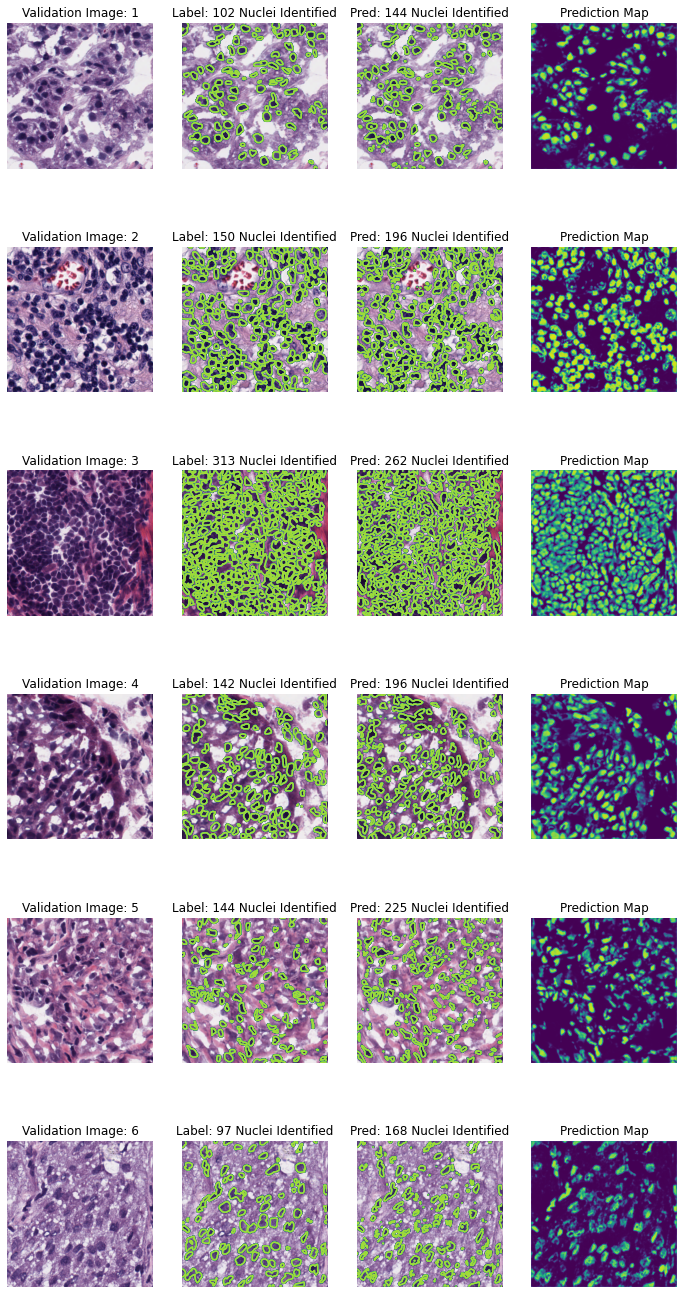

In [141]:
# Sample means and stds for un_normalization function
means = np.array([0.53955701, 0.38888616, 0.56235658])
stds = np.array([0.21415865, 0.2144178,  0.16906027])
from functions import un_standardize

# Emply lists to compare numbers of nuclei segmentations
n_nuclei_label = []
n_nuclei_pred = []


fig, axis = plt.subplots(6, 4, figsize=(12, 24))

for i_val in tqdm(range(labels.shape[0])):
    
    ###
    # Plot the raw image
    axis[i_val][0].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][0].axis("off")
    axis[i_val][0].set_title('Validation Image: {}'.format(i_val + 1))
    
    
    
    ###
    # Plot image with label segmentations
    
    # Identify label clusters
    label_identified_nuclei = sklabel(labels[i_val], connectivity=1, background = 0)
    
    # Count clusters and append to list
    n_label_identified_nuclei = len(np.unique(label_identified_nuclei[label_identified_nuclei > 0]))
    n_nuclei_label.append(n_label_identified_nuclei)
    
    # Make plot
    axis[i_val][1].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][1].contour(labels[i_val])
    axis[i_val][1].set_title('Label: {} Nuclei Identified'.format(n_label_identified_nuclei))
    axis[i_val][1].axis("off")

    
    ###
    # Plot image with model prediction segmentations
    
    # Apply threshold of 0.5 
    tmp_pred = preds[i_val] > 0.5
    
    # Identify pred sementations clusters
    pred_identified_nuclei = sklabel(tmp_pred, connectivity=1, background = 0)
    
    # Count prediction clusters and append to list
    n_pred_identified_nuclei = len(np.unique(pred_identified_nuclei[pred_identified_nuclei > 0]))
    n_nuclei_pred.append(n_pred_identified_nuclei)
    
    axis[i_val][2].imshow(un_standardize(imgs[i_val], means, stds))
    axis[i_val][2].contour(tmp_pred)
    axis[i_val][2].set_title('Pred: {} Nuclei Identified'.format(n_pred_identified_nuclei))
    axis[i_val][2].axis("off")
    
    ###
    # Plot prediction map unthresholded
    tmp_im = axis[i_val][3].imshow(preds[i_val], vmin = 0, vmax = 1, cmap = 'viridis')
    axis[i_val][3].set_title('Prediction Map')
    axis[i_val][3].axis("off")

# Convert lists to numpy arrays and concatenate
n_nuclei_compare = np.array([
    np.array(n_nuclei_label),
    np.array(n_nuclei_pred)
])

Now we compute the average percentage of "off" nuclei between label and prediction. 

In [54]:
percentage_off = np.mean(np.abs(n_nuclei_compare[0] - n_nuclei_compare[1]) / n_nuclei_compare[0])

print('Average Percentage of Devition between n Nuclei Label and Pred = {:.2f} %'.format(100 * percentage_off))

Average Percentage of Devition between n Nuclei Label and Pred = 42.60 %


The average amount of misclassification seems rather high. However, this metric only counts the numbers of segmented nuclei. By visual comparison, the prediction looks very similar to the label data. Therefore, a voxel-wise assessment of prediction accuracy is beneficial.   

For this, we will calculate a confusion matrix for binary classification. 

In [142]:
def confusion_matrix(X_label, X_pred, print_tab = False):
    """
    Helper Function to calculate and display a binary confusion matrix
    
    INPUT:
    X_label: Label Data; boolean numpy array (nd) 
    X_pred:  Prediction Data; boolean numpy array (nd) 
    print_tab: print the confusion matrix inline: boolean
    
    RETURN: 
    """
    
    # Reshape input variables
    X_label = np.array(X_label).astype(bool).ravel()
    X_pred = np.array(X_pred).astype(bool).ravel()
    
    # Total Pixels
    n_tot = X_label.shape[0]
    
    # Label == True Pixels
    n_lab = X_label.sum()
    
    # Label == False Pixels
    n_no_lab = n_tot - n_lab
    
    # Pred = True Pixels
    n_pred = X_pred.sum()
    
    # Pred = False Pixels
    n_no_pred = n_tot - n_pred
        
    # True Positives
    tp = (X_label * X_pred).sum()
    
    # True Negatives
    tn = (np.logical_not(X_label) * np.logical_not(X_pred)).sum()
    
    # False Positives
    # True Predictions - True Positives
    fp = n_pred - tp
    
    # False Negatives
    # No Predictions - True negatives
    fn = n_no_pred - tn
    
    if print_tab:
        print('               Pred TRUE \t Pred FALSE')
        print('Label TRUE  \t {:.2f} \t \t {:.2f} \t \t {:.2f}'.format(tp/n_tot,fn/n_tot,n_lab/n_tot))
        print('Label FALSE \t {:.2f} \t \t {:.2f} \t \t {:.2f}'.format(fp/n_tot,tn/n_tot,n_no_lab/n_tot))
        print('                 {:.2f} \t\t {:.2f} '.format(n_pred/n_tot,n_no_pred/n_tot))        
    
    return n_tot, n_lab, n_no_lab, n_pred, n_no_pred, np.array([[tp, fp],[fn, tn]]), np.array([[tp, fp],[fn, tn]])/n_tot

This confusion matrix function definition will go in the functions.py file

In [143]:
_ = confusion_matrix(labels, preds>0.5, print_tab = True)

               Pred TRUE 	 Pred FALSE
Label TRUE  	 0.20 	 	 0.06 	 	 0.26
Label FALSE 	 0.04 	 	 0.70 	 	 0.74
                 0.24 		 0.76 
